In [103]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
import math
import warnings
warnings.filterwarnings('ignore')

# Dataset dengan Model Boosting dan Bagging
## Penjelasan Metrik Evaluasi

Dalam analisis ini, kita akan menggunakan tiga metrik evaluasi utama untuk menilai performa model:

### 1. Mean Squared Error (MSE)
MSE mengukur rata-rata dari kuadrat kesalahan antara nilai prediksi dan nilai aktual.

**Persamaan Matematika:**
$$ MSE = \frac{Σ(y_i - ŷ_i)^2}{n}$$

Dimana:
- $n$ = jumlah data
- $y_i$ = nilai aktual pada data ke-i
- $ŷ_i$ = nilai prediksi pada data ke-i

**Interpretasi:**
- Nilai MSE selalu positif
- Semakin kecil nilai MSE, semakin baik model dalam melakukan prediksi
- MSE memberikan penalti lebih besar pada kesalahan yang besar karena menggunakan kuadrat

### 2. Root Mean Squared Error (RMSE)
RMSE adalah akar kuadrat dari MSE, yang memberikan nilai error dalam unit yang sama dengan variabel target.

**Persamaan Matematika:**
$$RMSE = \sqrt{MSE} = \sqrt{\frac{Σ(y_i - \hat{y}_i)^2}{n}}$$

**Interpretasi:**
- RMSE memiliki unit yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan
- Semakin kecil nilai RMSE, semakin baik model dalam melakukan prediksi
- Seperti MSE, RMSE juga memberikan penalti lebih pada kesalahan yang besar

### 3. Coefficient of Determination (R²)
R² mengukur proporsi variasi dalam variabel target yang dapat dijelaskan oleh model.

**Persamaan Matematika:**
$$R^2 = 1 - \frac{\sum(y_i - ŷ_i)^2}{ \sum(y_i - ȳ)^2}$$

Dimana:
- $ȳ$ = rata-rata nilai aktual
- Pembilang = Sum of Squares of Residuals (SSR)
- Penyebut = Total Sum of Squares (SST)

**Interpretasi:**
- $R^2$ biasanya bernilai antara 0 dan 1 (dalam kasus tertentu bisa negatif)
- $R^2$ = 1 berarti model dapat menjelaskan semua variabilitas data
- $R^2$ = 0 berarti model tidak dapat menjelaskan variabilitas data sama sekali
- Semakin tinggi nilai R², semakin baik model dalam menjelaskan variasi data

## Penjelasan Model Machine Learning

Dalam analisis ini, kita akan menggunakan beberapa model machine learning dari kelompok Boosting dan Bagging:

### Model Boosting:
Boosting adalah teknik ensemble yang membangun model secara sekuensial dimana setiap model mencoba memperbaiki kesalahan dari model sebelumnya.

#### 1. Gradient Boosting Regressor
Gradient Boosting membangun model secara sekuensial dengan fokus pada residual (kesalahan) dari model sebelumnya. Setiap model baru mencoba untuk memprediksi residual model sebelumnya.

**Algoritma Secara Sederhana:**
1. Inisialisasi model dengan nilai prediksi awal (biasanya rata-rata target)
2. Untuk setiap iterasi:
   - Hitung residual (selisih antara nilai aktual dan prediksi)
   - Latih model baru (biasanya decision tree) untuk memprediksi residual
   - Update prediksi dengan menambahkan hasil prediksi model baru yang telah dikalikan dengan learning rate
3. Gabungkan semua model untuk mendapatkan prediksi akhir

#### 2. AdaBoost Regressor
AdaBoost (Adaptive Boosting) membangun model secara sekuensial dengan memberikan bobot lebih pada data yang salah diprediksi.

**Algoritma Secara Sederhana:**
1. Berikan bobot yang sama untuk semua data
2. Untuk setiap iterasi:
   - Latih model dasar (weak learner)
   - Evaluasi kesalahan dan hitung bobot model
   - Perbarui bobot data (data yang salah diprediksi mendapat bobot lebih besar)
3. Gabungkan semua model dengan bobot masing-masing untuk prediksi akhir

### Model Bagging:

Bagging (Bootstrap Aggregating) adalah teknik ensemble yang membangun beberapa model secara paralel dari sampel data yang berbeda dan menggabungkan hasilnya.

#### 1. Random Forest Regressor
Random Forest adalah ensemble dari decision tree yang dilatih pada sampel bootstrap dari data asli dengan pemilihan fitur acak.

**Algoritma Secara Sederhana:**
1. Untuk setiap tree dalam forest:
   - Ambil sampel bootstrap dari data (sampling dengan pengembalian)
   - Pada setiap node, pilih subset acak dari fitur
   - Latih decision tree dengan data dan fitur yang dipilih
2. Rata-ratakan hasil prediksi dari semua tree untuk mendapatkan prediksi akhir

#### 2. Bagging Regressor
Bagging Regressor secara umum menerapkan teknik bagging pada model dasar apa pun. Dalam analisis ini, kita akan menggunakan Decision Tree sebagai model dasar.

**Algoritma Secara Sederhana:**
1. Untuk setiap estimator:
   - Ambil sampel bootstrap dari data (sampling dengan pengembalian)
   - Latih model dasar dengan sampel data tersebut
2. Rata-ratakan hasil prediksi dari semua estimator untuk mendapatkan prediksi akhir

In [55]:
def hitung_metrik_evaluasi(y_true, y_pred, y_pred_proba=None):
    # Akurasi
    # Akurasi = (TP + TN) / (TP + TN + FP + FN)
    akurasi = accuracy_score(y_true, y_pred)

    # Presisi
    # Presisi = TP / (TP + FP)
    presisi = precision_score(y_true, y_pred, average='macro')

    # Recall (Sensitivity)
    # Recall = TP / (TP + FN)
    recall = recall_score(y_true, y_pred, average='macro')

    # F1-Score
    # F1 = 2 * (Presisi * Recall) / (Presisi + Recall)
    f1 = f1_score(y_true, y_pred, average='macro')

    # AUC-ROC (hanya jika ada probability scores)
    auc_roc = None
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

    return {
        'y_pred_proba': y_pred_proba,
        'y_true': y_true,
        'Akurasi': akurasi,
        'Presisi': presisi,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

def tampilkan_evaluasi(model_results, title):
    # Konversi hasil ke DataFrame untuk tampilan yang lebih baik
    results_df = pd.DataFrame(model_results).T

    # Menampilkan hasil dalam bentuk tabel
    print(f"=== Hasil Evaluasi Model untuk {title} ===")
    print(results_df[['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'AUC-ROC']])
    print("\n")

    # Visualisasi hasil
    plt.figure(figsize=(15, 5))

    # Akurasi (lebih besar lebih baik)
    plt.subplot(1, 5, 1)
    sns.barplot(x=results_df.index, y='Akurasi', data=results_df)
    plt.title('Akurasi')
    plt.xlabel('Model')
    plt.ylabel('Akurasi')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Presisi (lebih besar lebih baik)
    plt.subplot(1, 5, 2)
    sns.barplot(x=results_df.index, y='Presisi', data=results_df)
    plt.title('Presisi')
    plt.xlabel('Model')
    plt.ylabel('Presisi')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Recall (lebih besar lebih baik)
    plt.subplot(1, 5, 3)
    sns.barplot(x=results_df.index, y='Recall', data=results_df)
    plt.title('Recall')
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # F1-Score (lebih besar lebih baik)
    plt.subplot(1, 5, 4)
    sns.barplot(x=results_df.index, y='F1-Score', data=results_df)
    plt.title('F1-Score')
    plt.xlabel('Model')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # AUC-ROC (lebih besar lebih baik)
    plt.subplot(1, 5, 5)
    sns.barplot(x=results_df.index, y='AUC-ROC', data=results_df)
    plt.title('AUC-ROC')
    plt.xlabel('Model')
    plt.ylabel('AUC-ROC')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Cek jumlah model untuk menentukan subplot layout
    roc_models = [name for name in model_results if model_results[name]['y_pred_proba'] is not None]
    n_models = len(roc_models)

    if n_models > 0:
        n_cols = min(n_models, 3)
        n_rows = (n_models + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        axes = np.array(axes).reshape(-1)

        for i, model_name in enumerate(roc_models):
            y_true = model_results[model_name]['y_true']
            y_pred_proba = model_results[model_name]['y_pred_proba']

            ax = axes[i]

            # Multiclass ROC Curve
            if len(np.unique(y_true)) > 2:
                classes = np.unique(y_true)
                y_true_bin = label_binarize(y_true, classes=classes)

                for j, class_label in enumerate(classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_pred_proba[:, j])
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

                ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
                ax.set_title(f'ROC Curve - {model_name}')
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.legend(loc='lower right', fontsize='small')
                ax.grid(True)

        # Hapus subplot kosong jika ada
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.suptitle('ROC Curves per Model', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

# Implementasi pada Dataset
## Dataset 1: Heart Disease
### 1. Memuat dan Menyiapkan Data

In [10]:
df_heartdisease = pd.read_csv('HeartDisease.csv')
print('deskripsikan tiap kolom:')
display(df_heartdisease.describe())
print('\ninfo tiap kolom:')
display(df_heartdisease.info())
print('\nisi tiap kolom:')
display(df_heartdisease.head())

deskripsikan tiap kolom:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


None


isi tiap kolom:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### 2. Pra-pemrosesan Data

In [11]:
# Bersihkan data dengan menghapus baris yang memiliki missing values
df_heartdisease.dropna(inplace=True)

# Pilih target - 'num' sebagai variabel target (0 = tidak ada penyakit, 1-4 = tingkat keparahan)
target = 'num'
X = df_heartdisease.drop(target, axis=1)
y = df_heartdisease[target]

# Identifikasi kolom numerik dan kategorikal
# Berdasarkan info dataset, semua kolom memiliki tipe numerik (int/float)
# Namun beberapa kolom sebenarnya adalah kategorikal:
# - sex, cp, fbs, restecg, exang, slope, ca, thal adalah kategorikal
# - age, trestbps, chol, thalach, oldpeak adalah numerik kontinu

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print(f"Kolom numerik kontinu: {numeric_cols}")
print(f"Kolom kategorikal: {categorical_cols}")

# Preprocessing untuk kolom numerik dan kategorikal
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Untuk handle missing values jika ada
    ('scaler', StandardScaler())  # Standarisasi nilai numerik
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Untuk handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encoding kategori
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")
print("\nDistribusi kelas pada data training:")
print(y_train.value_counts(normalize=True))
print("\nDistribusi kelas pada data testing:")
print(y_test.value_counts(normalize=True))

Kolom numerik kontinu: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Kolom kategorikal: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Jumlah data training: 237
Jumlah data testing: 60

Distribusi kelas pada data training:
num
0    0.540084
1    0.181435
3    0.118143
2    0.118143
4    0.042194
Name: proportion, dtype: float64

Distribusi kelas pada data testing:
num
0    0.533333
1    0.183333
3    0.116667
2    0.116667
4    0.050000
Name: proportion, dtype: float64


### 3. Membangun dan Mengevaluasi Model

Melatih model Logistic Regression...
Selesai melatih model Logistic Regression

Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting

Melatih model AdaBoost...
Selesai melatih model AdaBoost

Melatih model Random Forest...
Selesai melatih model Random Forest

Melatih model Bagging...
Selesai melatih model Bagging

=== Hasil Evaluasi Model untuk Heart Disease Classification ===
                      Akurasi   Presisi    Recall  F1-Score   AUC-ROC
Logistic Regression      0.65  0.338974  0.401542  0.350964  0.834191
Gradient Boosting    0.533333  0.248039  0.258117   0.24744   0.74061
AdaBoost                  0.6  0.344706  0.362013  0.349809  0.729846
Random Forest        0.566667  0.211059  0.246753     0.224  0.780489
Bagging              0.533333   0.23009  0.246185  0.236232  0.784351




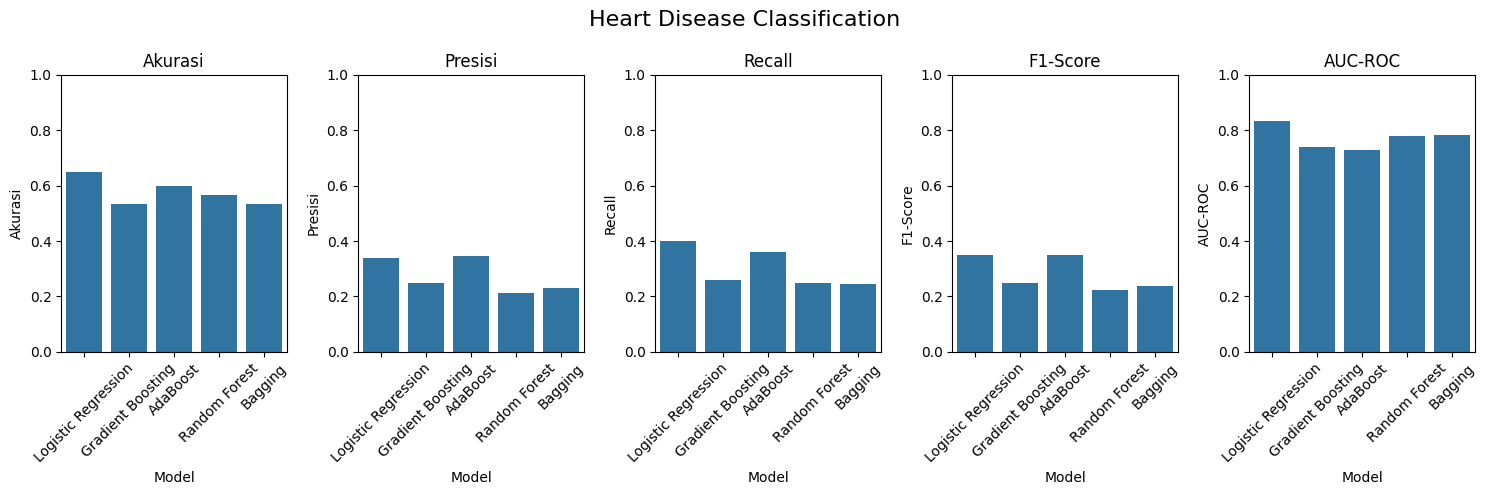

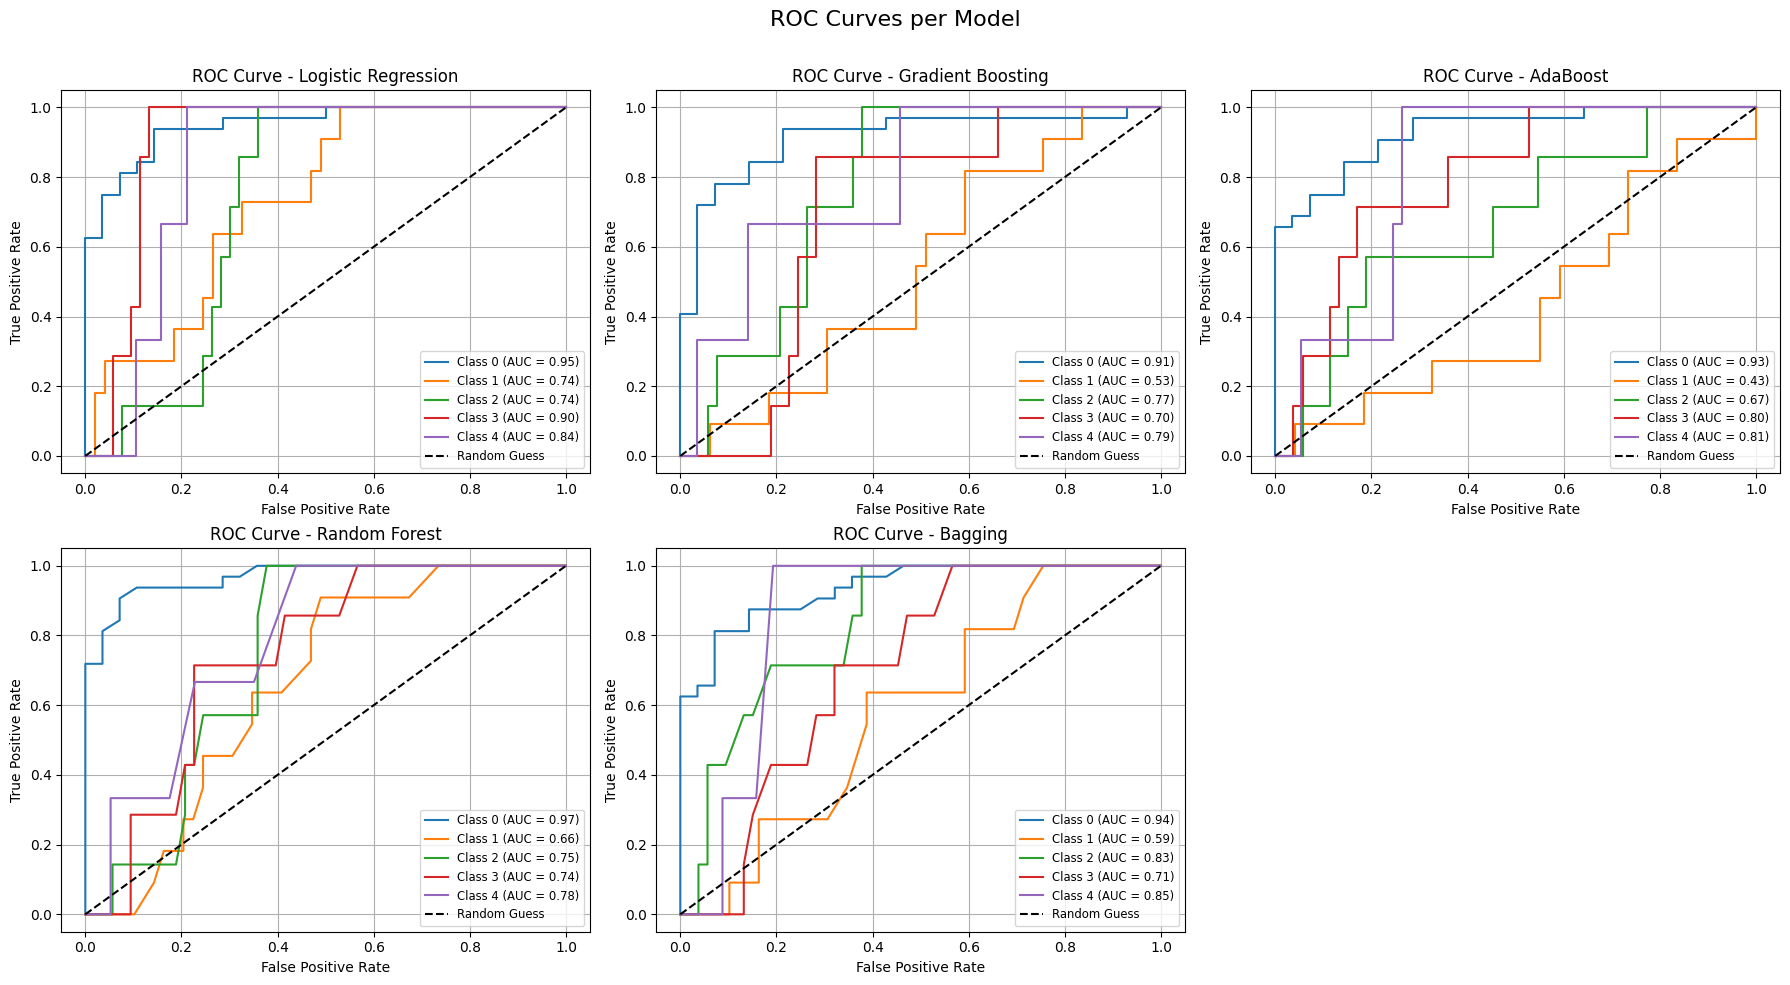

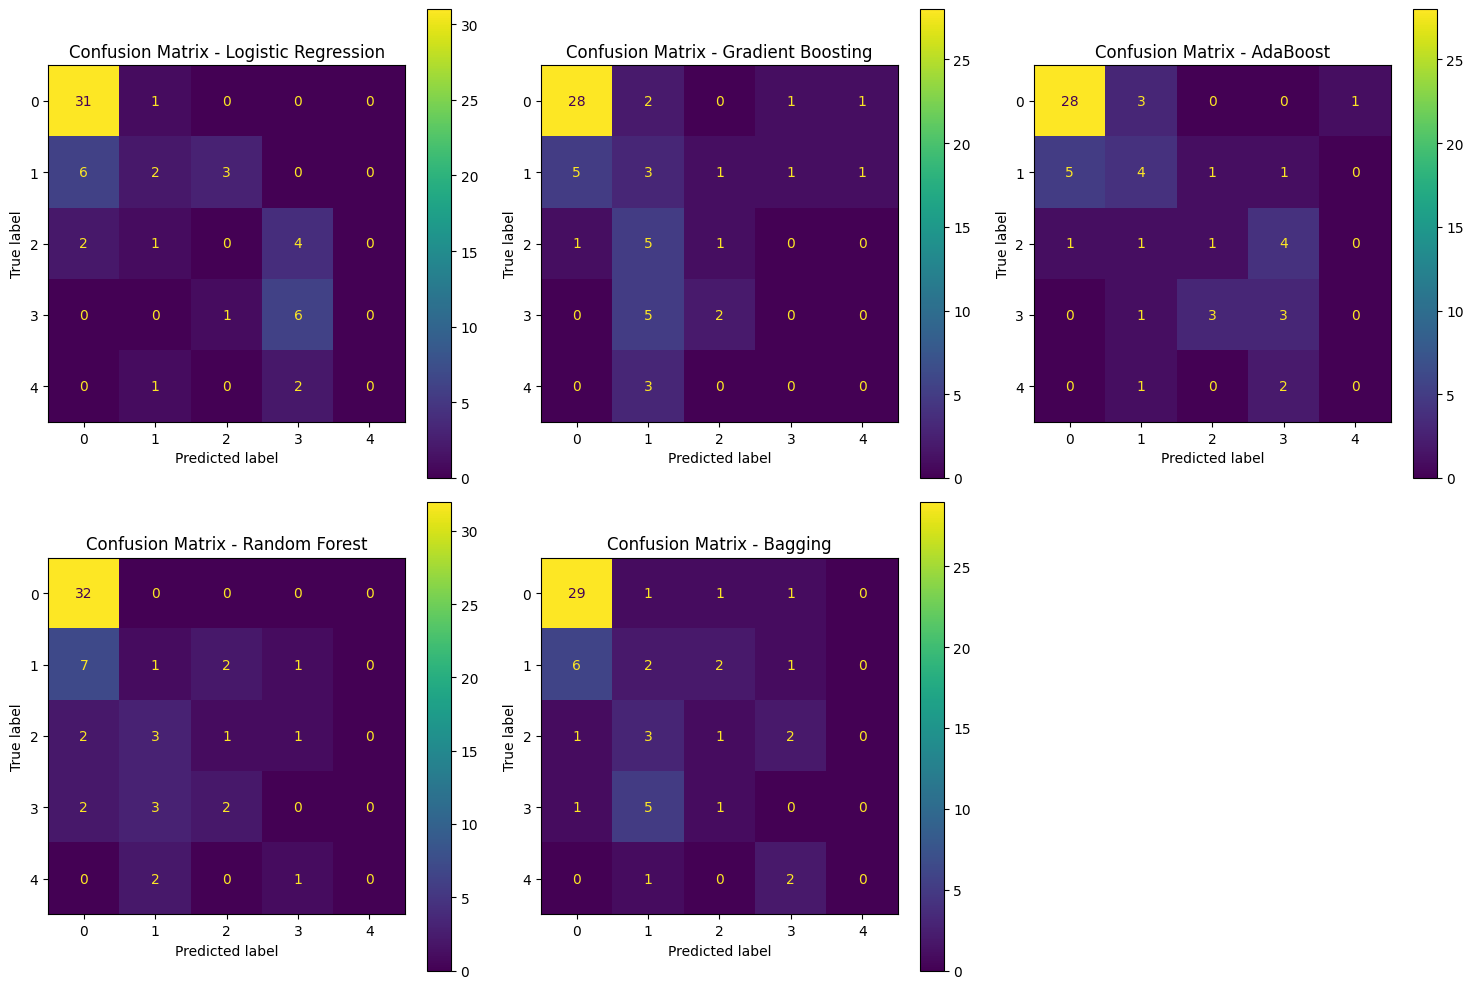

In [56]:
# Model dasar untuk perbandingan (Logistic Regression untuk multi-class)
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Model Boosting
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

ada_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
])

# Model Bagging
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

bag_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        random_state=42))
])

# Daftar model yang akan dievaluasi
models = {
    'Logistic Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
heart_results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Untuk model yang bisa predict_proba, hitung juga ROC AUC (multi-class)
    y_pred_proba = None
    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)

    # Hitung metrik evaluasi
    heart_results[name] = hitung_metrik_evaluasi(y_test, y_pred, y_pred_proba)
    print(f"Selesai melatih model {name}\n")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(heart_results, "Heart Disease Classification")

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 3, i+1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca())
    plt.title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

### Analisis Hasil
#### Catatan:
- Akurasi dan semua metrik klasifikasi cenderung rendah → mengindikasikan dataset mungkin tidak seimbang atau model belum cukup kompleks.
- Logistic Regression unggul di seluruh metrik (kecuali recall yang bersaing).
- Gradient Boosting & Bagging memiliki AUC-ROC > 0.73 tetapi kinerja klasifikasinya tidak konsisten.

#### Analisis ROC Curve (Visual)
- ROC Curve menunjukkan kemampuan model membedakan antar kelas.
- Logistic Regression menunjukkan kurva ROC yang paling stabil dan AUC terbaik (Class 0 = 0.95) → konsisten dengan skor AUC-ROC global.
- AdaBoost dan Bagging juga memperlihatkan ROC yang baik di beberapa kelas, meskipun metrik lain rendah.
- Random Forest cenderung overfitting terhadap beberapa kelas (Class 0 tinggi, lainnya rendah).
- Gradient Boosting gagal pada Class 1 (AUC = 0.53) → nyaris tidak lebih baik dari tebakan acak.

#### Kesimpulan:
- Logistic Regression adalah model terbaik secara konsisten, baik dari akurasi, F1-score, maupun AUC.
- Model ensemble seperti Random Forest, Bagging, dan Gradient Boosting tampaknya kurang efektif di sini, bisa jadi karena dataset terlalu kecil atau tidak seimbang.
- Diperlukan:
  - Peningkatan preprocessing (e.g. SMOTE jika imbalance),
  - Feature engineering,
  - Tuning hyperparameter, terutama pada ensemble model.

## Dataset 2: Citarum Water
### 1. Memuat dan Menyiapkan Data

In [57]:
df_citarumwater = pd.read_csv('CitarumWater.csv')
print('deskripsikan tiap kolom:')
display(df_citarumwater.describe())
print('\ninfo tiap kolom:')
display(df_citarumwater.info())
print('\nisi tiap kolom:')
display(df_citarumwater.head())

deskripsikan tiap kolom:


,No,pH,TSS,DO,BOD,COD,Nitrat,FecalColiform,Fosfat,IP,Class
count,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,1250.50000,7.032305,27.856368,3.882005,4.005476,20.511768,1.970393,1.418937e+04,0.074547,1.365796,1.650000
std,721.83216,0.578179,10.551351,2.249329,2.697375,8.969809,1.175104,2.526550e+05,0.320970,1.220703,0.547375
min,1.00000,6.002441,5.000000,0.002140,1.640000,5.440000,0.003784,5.000000e+01,0.004300,0.430000,1.000000
25%,625.75000,6.520722,23.597278,1.925925,2.754331,14.999275,0.955443,2.924867e+02,0.048199,0.840000,1.000000
50%,1250.50000,7.056001,27.671133,3.892147,3.800133,20.044252,1.920408,5.375973e+02,0.065606,1.170000,2.000000
75%,1875.25000,7.531846,31.747063,5.828533,4.947965,25.155492,3.014985,7.829760e+02,0.083315,1.570000,2.000000
max,2500.00000,8.710000,318.000000,7.800000,55.300000,190.000000,5.240000,9.200000e+06,16.000000,14.900000,4.000000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             2500 non-null   int64  
 1   NamaSungai     2500 non-null   object 
 2   TitikPantau    2500 non-null   object 
 3   Waktu          2500 non-null   object 
 4   pH             2500 non-null   float64
 5   Temp           2500 non-null   object 
 6   TSS            2500 non-null   float64
 7   DO             2500 non-null   float64
 8   BOD            2500 non-null   float64
 9   COD            2500 non-null   float64
 10  Nitrat         2500 non-null   float64
 11  FecalColiform  2500 non-null   float64
 12  Fosfat         2500 non-null   float64
 13  O2             2500 non-null   object 
 14  IP             2500 non-null   float64
 15  Class          2500 non-null   int64  
dtypes: float64(9), int64(2), object(5)
memory usage: 312.6+ KB


None


isi tiap kolom:


,No,NamaSungai,TitikPantau,Waktu,pH,Temp,TSS,DO,BOD,COD,Nitrat,FecalColiform,Fosfat,O2,IP,Class
0,1,Citarum,Wangisagara,18/04/2018,7.57,25.55°C,11.0,6.11,3.30,6.10,1.08,17000.0,0.043,-,5.12,3
1,2,Citarum,Koyod,18/04/2018,7.69,25.55°C,13.0,6.20,5.31,12.50,1.85,28000.0,0.011,-,5.91,3
2,3,Citarum,Setelah IPAL Cisirung,18/04/2018,7.39,25.55°C,15.0,3.61,7.40,23.50,1.25,90000.0,0.230,-,7.76,3
3,4,Citarum,Nanjung,18/04/2018,7.49,25.55°C,17.0,3.17,8.13,27.50,1.21,300000.0,0.057,-,9.61,3
4,5,Citarum,Outlet Waduk Jatiluhur,18/04/2018,7.17,25.55°C,6.0,6.82,2.89,5.44,1.04,3000.0,0.110,-,2.44,2


### 2. Pra-pemrosesan Data

In [59]:
# Kolom yang tidak diperlukan untuk modeling
cols_to_drop = ['No', 'NamaSungai', 'TitikPantau', 'Waktu', 'Temp', 'O2']
df_citarumwater = df_citarumwater.drop(cols_to_drop, axis=1)

# Pilih target
target = 'Class'
X = df_citarumwater.drop(target, axis=1)
y = df_citarumwater[target]

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Catatan: Dari info dataset, semua kolom prediktor numerik (kecuali yang sudah di-drop)

print(f"Kolom numerik: {numeric_cols}")
print(f"Target classes: {y.unique()}")

# Preprocessing untuk kolom numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle potential missing values
    ('scaler', StandardScaler())  # Standardisasi fitur numerik
])

# Karena tidak ada kolom kategorikal yang tersisa, kita hanya perlu numeric transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ])

# Pisahkan data menjadi training dan testing dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Penting untuk dataset tidak seimbang
)

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")
print("\nDistribusi kelas pada data training:")
print(y_train.value_counts(normalize=True))
print("\nDistribusi kelas pada data testing:")
print(y_test.value_counts(normalize=True))

# Untuk verifikasi
print("\n5 sampel data training setelah preprocessing:")
sample_train = pd.DataFrame(X_train.iloc[:5].copy(), columns=X.columns)
print(sample_train)

Kolom numerik: ['pH', 'TSS', 'DO', 'BOD', 'COD', 'Nitrat', 'FecalColiform', 'Fosfat', 'IP']
Target classes: [3 2 4 1]

Jumlah data training: 2000
Jumlah data testing: 500

Distribusi kelas pada data training:
Class
2    0.5985
1    0.3790
3    0.0155
4    0.0070
Name: proportion, dtype: float64

Distribusi kelas pada data testing:
Class
2    0.598
1    0.380
3    0.016
4    0.006
Name: proportion, dtype: float64

5 sampel data training setelah preprocessing:
            pH        TSS        DO       BOD        COD    Nitrat  \
2029  7.875851  23.187597  3.658331  4.050847  27.576830  0.534684   
2149  7.768548  32.631245  6.197385  2.839598  12.421339  2.360424   
1273  6.771325  23.000580  3.204962  3.087359  21.834468  2.853114   
1338  6.256661  29.821100  5.028897  3.758336  18.166143  2.879116   
980   6.453505  32.867580  5.856705  3.565166  24.167913  2.988861   

      FecalColiform    Fosfat    IP  
2029     905.745109  0.087943  1.26  
2149     868.895535  0.032715  0.74  
12

### 3. Membangun dan Mengevaluasi Model

Melatih model Logistic Regression...
Selesai melatih model Logistic Regression

Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting

Melatih model AdaBoost...
Selesai melatih model AdaBoost

Melatih model Random Forest...
Selesai melatih model Random Forest

Melatih model Bagging...
Selesai melatih model Bagging

=== Hasil Evaluasi Model untuk Heart Disease Classification ===
                    Akurasi   Presisi    Recall  F1-Score   AUC-ROC
Logistic Regression    0.97  0.983765  0.924232  0.949519  0.998252
Gradient Boosting       1.0       1.0       1.0       1.0       1.0
AdaBoost              0.978  0.493485       0.5    0.4967    0.9935
Random Forest           1.0       1.0       1.0       1.0       1.0
Bagging                 1.0       1.0       1.0       1.0       1.0




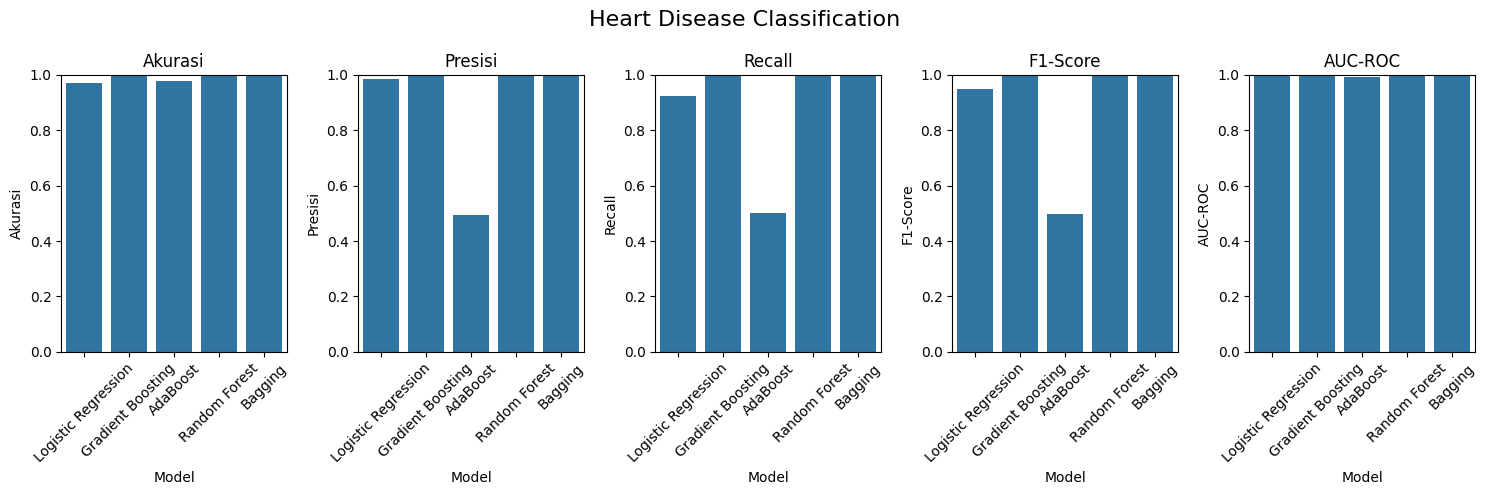

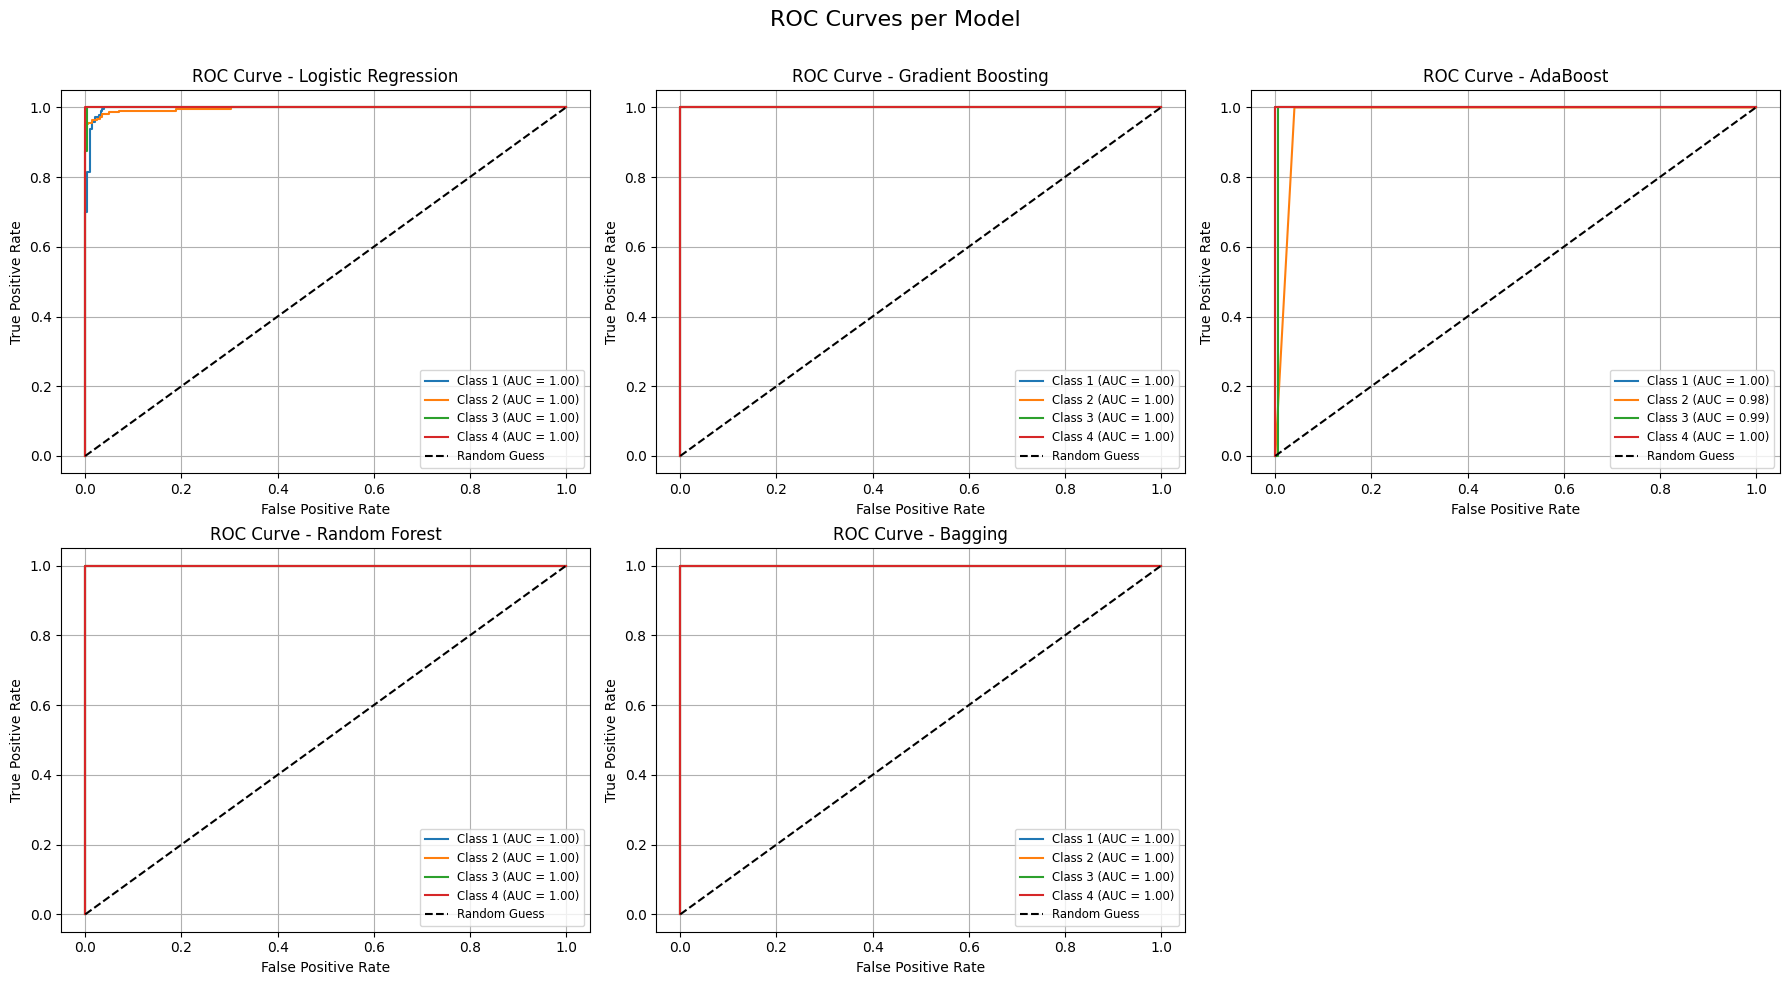

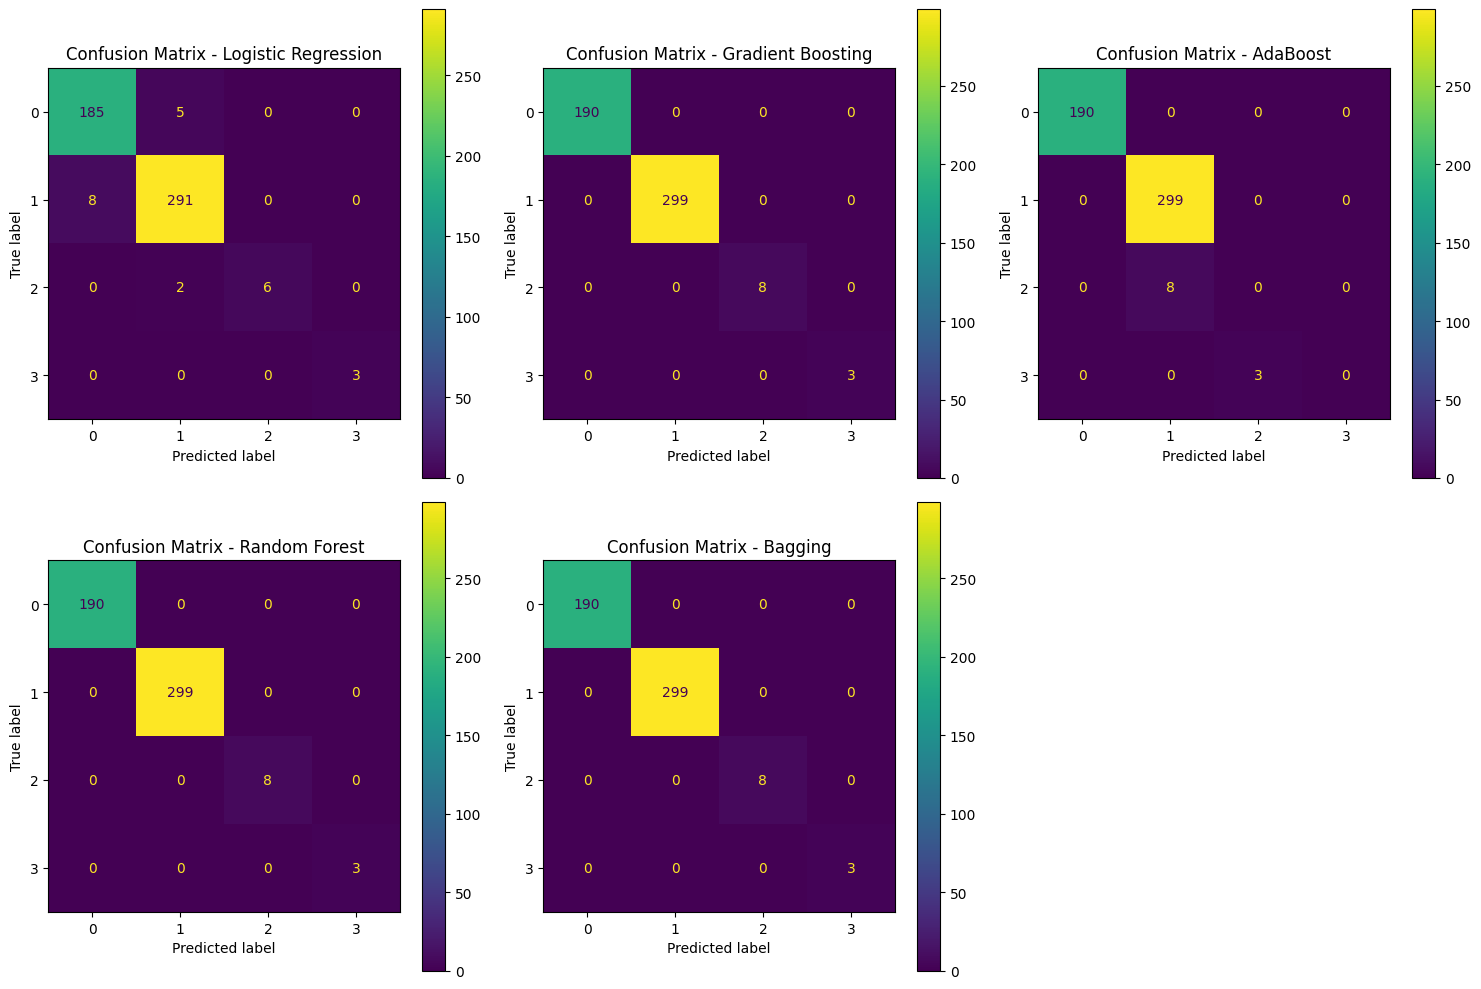

In [60]:
# Model dasar untuk perbandingan (Logistic Regression untuk multi-class)
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Model Boosting
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

ada_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
])

# Model Bagging
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

bag_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        random_state=42))
])

# Daftar model yang akan dievaluasi
models = {
    'Logistic Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
heart_results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Untuk model yang bisa predict_proba, hitung juga ROC AUC (multi-class)
    y_pred_proba = None
    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)

    # Hitung metrik evaluasi
    heart_results[name] = hitung_metrik_evaluasi(y_test, y_pred, y_pred_proba)
    print(f"Selesai melatih model {name}\n")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(heart_results, "Citarum Water Classification")

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 3, i+1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca())
    plt.title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

### Analisis Hasil
#### Analisis ROC Curve (Visual & Nilai AUC)
- Semua model kecuali AdaBoost menunjukkan AUC = 1.00 → ROC curve berada di pojok kiri atas sempurna.
- AdaBoost masih sangat tinggi (AUC: 0.98–1.00), tetapi ada penurunan kecil di Class 2 dan Class 3.
- Tidak ada indikasi kesalahan prediksi dari ROC untuk Gradient Boosting, Random Forest, dan Bagging.

#### Catatan Penting
Hasil sempurna (akurasi, AUC, F1-score = 1.0) jarang realistis dalam konteks data nyata, kecuali:
  - Dataset sangat kecil,
  - Ada data leakage (fitur yang bocor dari label),
  - Tidak ada data split yang benar (model diuji pada data training).

####  Anomali pada AdaBoost
- Meski akurasi tinggi (0.978), presisi dan recall drop drastis ke ~0.5 → berarti model hanya bagus untuk beberapa kelas atau banyak prediksi salah pada kelas minoritas.
- AUC tetap tinggi → model bisa membedakan kelas tapi tidak mengeksekusi prediksi kelas dengan baik.

## Dataset 3: Income
### 1. Memuat dan Menyiapkan Data

In [62]:
df_income = pd.read_csv('income.csv')
print('deskripsikan tiap kolom:')
display(df_income.describe())
print('\ninfo tiap kolom:')
display(df_income.info())
print('\nisi tiap kolom:')
display(df_income.head())

deskripsikan tiap kolom:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None


isi tiap kolom:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 2. Pra-pemrosesan Data

In [100]:
# bersihkan dataset
df_income.dropna(inplace=True)

# Pilih target (diasumsikan 'income' sebagai target)
target = 'income'
X = df_income.drop(target, axis=1)
y = df_income[target].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Kolom numerik: {numeric_cols}")  # ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
print(f"Kolom kategorikal: {categorical_cols}")  # ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Preprocessing untuk kolom numerik dan kategorikal
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Untuk menangani missing values di kolom numerik
    ('scaler', StandardScaler())  # Standardisasi data numerik
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Untuk menangani missing values di kolom kategorikal
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encoding variabel kategorikal
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Kolom numerik: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Kolom kategorikal: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Jumlah data training: 38096
Jumlah data testing: 9525


### 3. Membangun dan Mengevaluasi Model

Melatih model Linear Regression...
Selesai melatih model Linear Regression
Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting
Melatih model AdaBoost...
Selesai melatih model AdaBoost
Melatih model Random Forest...
Selesai melatih model Random Forest
Melatih model Bagging...
Selesai melatih model Bagging
=== Hasil Evaluasi Model untuk Dataset Income ===
                    Akurasi   Presisi    Recall  F1-Score   AUC-ROC
Linear Regression  0.833596  0.801814  0.716094  0.742666  0.890273
Gradient Boosting  0.859423  0.840906  0.759055  0.787319  0.915154
AdaBoost           0.844409  0.823682  0.729122  0.758407  0.893645
Random Forest      0.849659  0.808397  0.767826  0.784448  0.900034
Bagging            0.850289  0.809597  0.768244  0.785138  0.899871




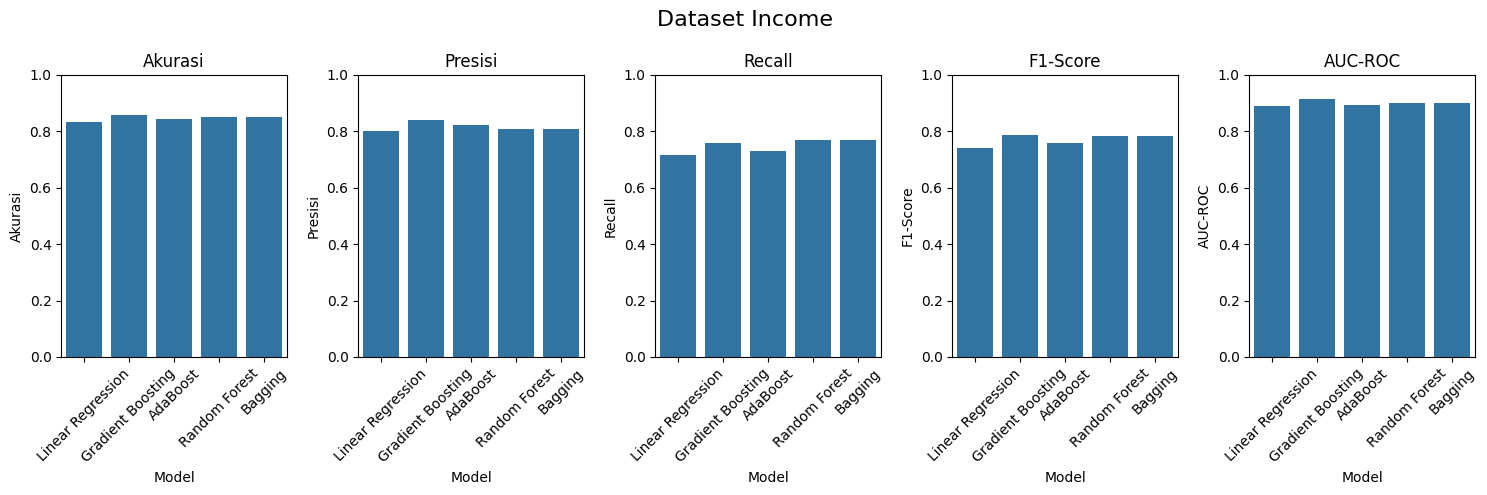

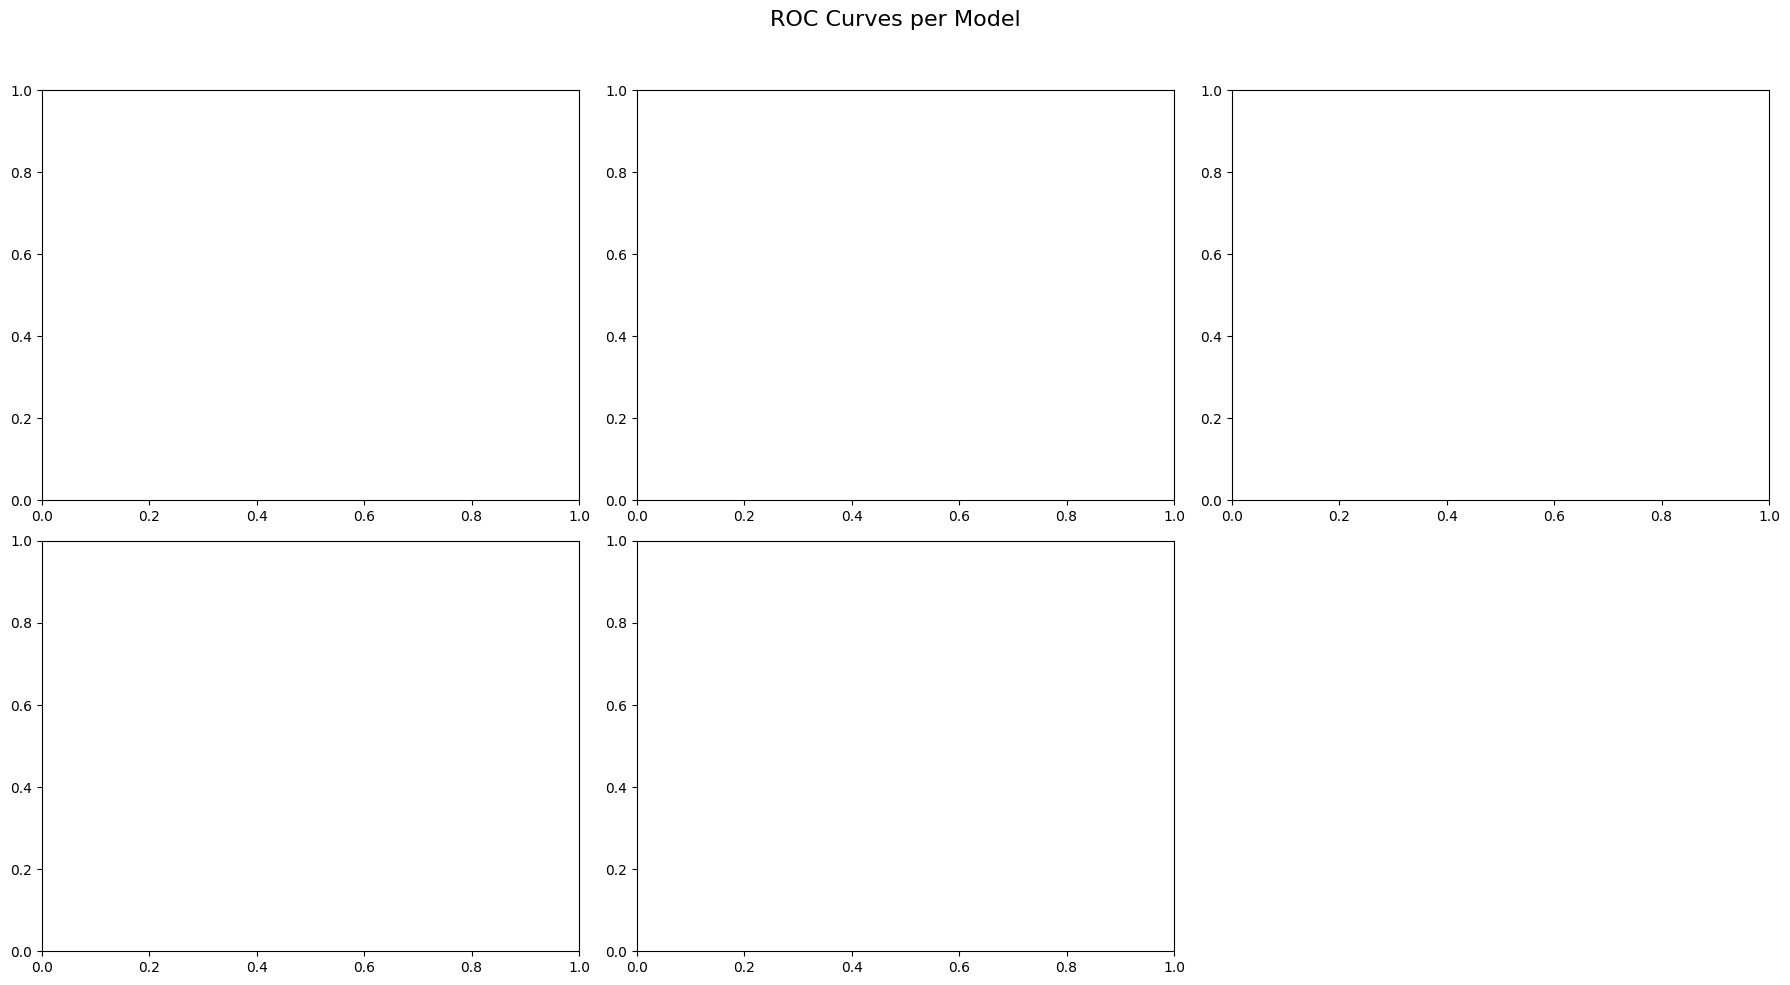

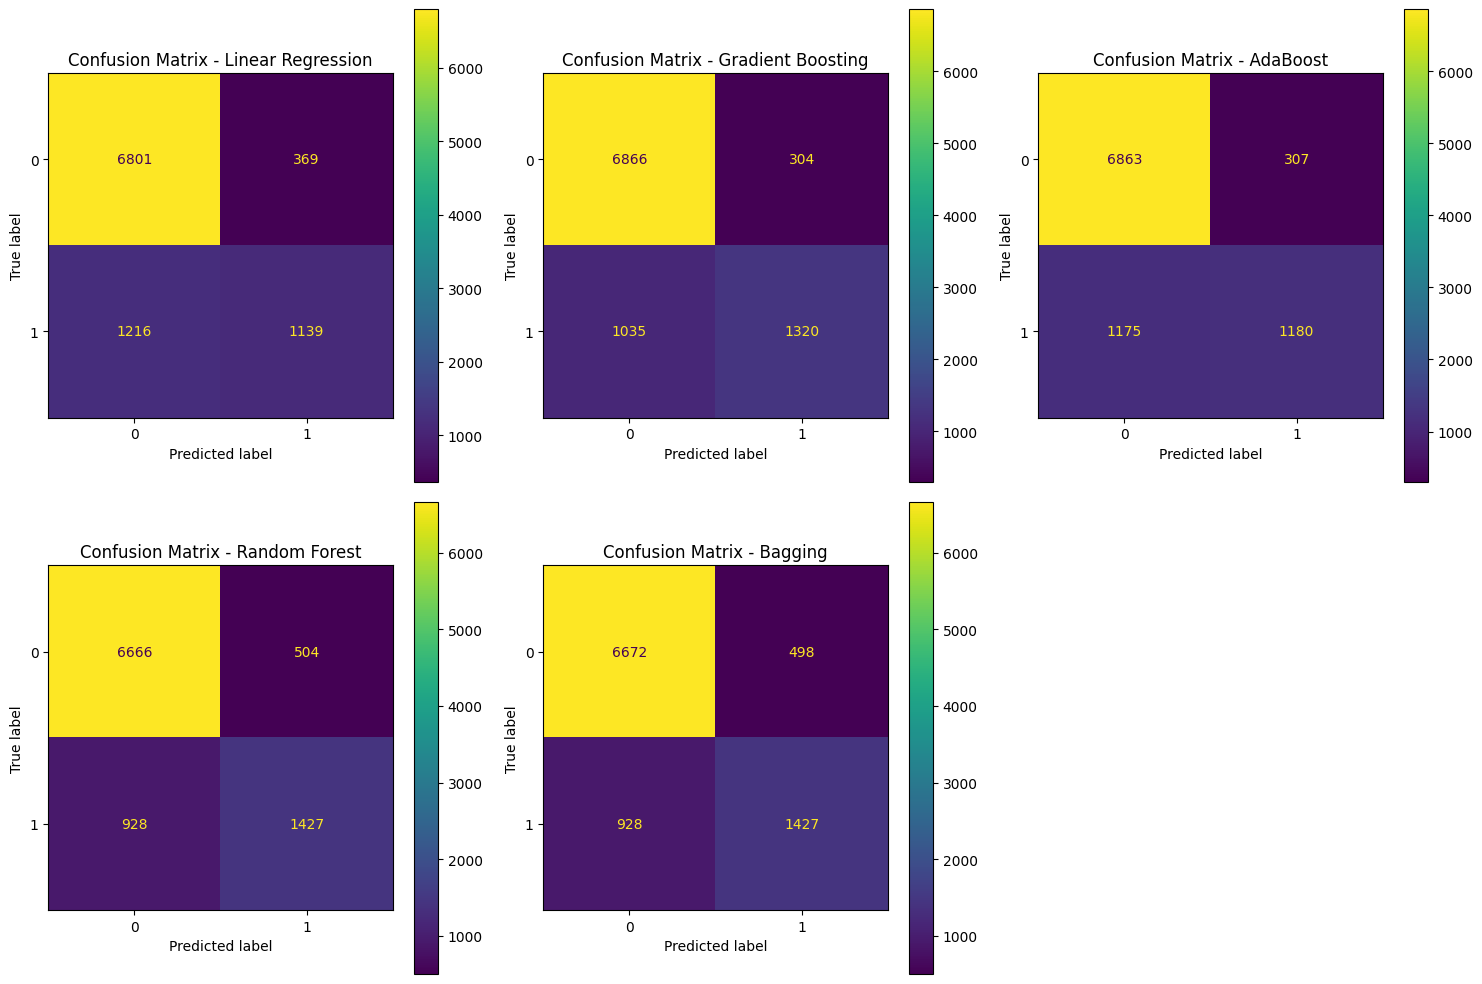

In [110]:
# Model dasar untuk perbandingan
base_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

# Model Boosting
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

ada_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', AdaBoostRegressor(n_estimators=100, random_state=42))])

# Model Bagging
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

bag_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor(),
                                                           n_estimators=100, random_state=42))])

# Daftar model yang akan dievaluasi
models = {
    'Linear Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) > 0.5

    # Hitung metrik evaluasi
    results[name] = hitung_metrik_evaluasi(y_test, y_pred, y_pred_proba=model.predict_proba(X_test) if hasattr(model, 'predict_proba') else model.predict(X_test))

    print(f"Selesai melatih model {name}")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(results, "Dataset Income")

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 3, i+1)
    y_pred = model.predict(X_test) > 0.5
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca())
    plt.title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

### Analisis Hasil
#### Analisis
- Gradient Boosting menunjukkan performa terbaik di semua metrik, menandakan kemampuannya menangkap pola non-linear dengan baik.
- Random Forest dan Bagging juga sangat kompetitif, dengan trade-off sedikit pada presisi dan AUC dibanding Gradient Boosting.
- AdaBoost sedikit tertinggal, terutama pada recall, namun masih lebih unggul dari model baseline.
- Linear Regression memberikan baseline yang cukup solid, tapi tertinggal dalam recall dan F1, menandakan keterbatasannya dalam menangani kompleksitas data klasifikasi income.

#### Kesimpulan
- Untuk aplikasi real-world klasifikasi pendapatan, Gradient Boosting adalah pilihan paling optimal.
- Jika prioritas adalah efisiensi dan interpretabilitas, Linear Regression masih layak, namun dengan akurasi dan generalisasi lebih rendah.
- Random Forest dan Bagging menjadi alternatif stabil, khususnya jika perlu model ensemble yang lebih tahan terhadap outlier dan variansi data.